<a href="https://colab.research.google.com/github/diNAZAvRik125/GNN_bmm23/blob/FullyConnectedAutoencoder/GNN_FullyConnectedAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import os
import os.path as osp
import json
import shutil
import pprint
import pandas as pd
import numpy as np

In [ ]:
os.chdir('/content')

In [ ]:
!git clone https://github.com/GraphGiraffe/GNN_bmm23.git
!ls GNN_bmm23

Cloning into 'GNN_bmm23'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 47 (delta 25), reused 43 (delta 21), pack-reused 0
Receiving objects: 100% (47/47), 41.13 KiB | 3.43 MiB/s, done.
Resolving deltas: 100% (25/25), done.
data_utils.py  GNN_models.py	      training.py	 utils.py
GNN_layers.py  preprocess_dataset.py  training_utils.py  visualize.py


In [ ]:
!pip install torch_geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html


In [ ]:
import torch
from torch_geometric.loader import DataLoader

In [ ]:

os.chdir('/content/GNN_bmm23')

In [ ]:
from GNN_models import FlowGNN
from data_utils import read_dataset, make_dataset
from training_utils import train_model, loss_mae, loss_mse

# Download data

In [ ]:
import gdown

if not osp.exists('data.tar.gz'):
  url = 'https://drive.google.com/uc?id=1abMcm4HTuXwQ453lpa9EKQ2zazKZB2wz'
  output = 'data.tar.gz'
  gdown.download(url, output, quiet=False)
else:
  print('file exists')

file exists


In [ ]:
os.makedirs('datasets', exist_ok=True)

In [ ]:
!tar -zxvf data.tar.gz --directory datasets/

Выходные данные были обрезаны до нескольких последних строк (5000).
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/002596.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/000381.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/001921.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/001909.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/001510.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/000197.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/000829.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/000815.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/002970.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/002637.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/000034.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/000008.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/002186.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/00079

In [ ]:
!ls -alhtr

total 451M
drwxr-xr-x 1 root root 4.0K Jul 23 07:43 ..
-rw-r--r-- 1 root root 2.8K Jul 23 07:43 GNN_layers.py
-rw-r--r-- 1 root root   19 Jul 23 07:43 .gitignore
-rw-r--r-- 1 root root 9.5K Jul 23 07:43 visualize.py
-rw-r--r-- 1 root root 4.6K Jul 23 07:43 utils.py
-rw-r--r-- 1 root root 6.5K Jul 23 07:43 training_utils.py
-rw-r--r-- 1 root root 3.1K Jul 23 07:43 training.py
-rw-r--r-- 1 root root  577 Jul 23 07:43 preprocess_dataset.py
-rw-r--r-- 1 root root 6.9K Jul 23 07:43 GNN_models.py
drwxr-xr-x 8 root root 4.0K Jul 23 07:43 .git
-rw-r--r-- 1 root root 9.6K Jul 23 07:43 data_utils.py
drwxr-xr-x 2 root root 4.0K Jul 23 07:44 __pycache__
-rw-r--r-- 1 root root 451M Jul 23 07:44 data.tar.gz
drwxr-xr-x 5 root root 4.0K Jul 23 07:44 .
drwxr-xr-x 3 root root 4.0K Jul 23 07:44 datasets


# Prepare data

In [ ]:
for root, dirs, files in os.walk('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/bcs/'):
  print(files)

dir_path = 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/sv'
os.makedirs(dir_path, exist_ok=True)

def boundary_func(y, params):
  u0 = params[0]
  c1 = params[1]
  c2 = params[2]
  k1 = params[3]
  k2 = params[4]
  H = 6
  u = (u0 / 2) * (1 - (y / (H/2))**2) * ((1 + c1 * np.sin(k1 *y)) + (1 + c2 * np.sin(k2 * y)))
  return u
big_data_list = list()

for file_csv in files:
  way_to_csv = os.path.join(root, file_csv)
  data = pd.read_csv(way_to_csv, header=None)

  x_lin = np.linspace(-3,3,100)
  u = boundary_func(x_lin, [data[0][0],data[0][2],data[0][3],data[0][4],data[0][5]])

  big_data_list.append(u)
  df = pd.DataFrame.from_dict(u)
  df.to_csv(os.path.join(dir_path, file_csv))
  #plt.plot(x_lin, u)

big_data = np.vstack(big_data_list)
del big_data_list
df_big_data_speed = pd.DataFrame.from_dict(big_data)
df_big_data_speed.to_csv('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/res.csv', header=None)

['001510.csv', '000785.csv', '001180.csv', '000278.csv', '000853.csv', '001218.csv', '001213.csv', '001244.csv', '000240.csv', '002318.csv', '000918.csv', '000236.csv', '001542.csv', '002302.csv', '001302.csv', '002355.csv', '001980.csv', '001975.csv', '002941.csv', '001520.csv', '000353.csv', '001932.csv', '000526.csv', '001619.csv', '002296.csv', '000395.csv', '002679.csv', '000188.csv', '000127.csv', '001827.csv', '000508.csv', '001548.csv', '002071.csv', '001119.csv', '001125.csv', '002630.csv', '000801.csv', '000216.csv', '001739.csv', '000781.csv', '000079.csv', '002619.csv', '001400.csv', '000052.csv', '000355.csv', '002329.csv', '000989.csv', '002013.csv', '001287.csv', '002252.csv', '001871.csv', '000098.csv', '002404.csv', '002871.csv', '000667.csv', '000920.csv', '002667.csv', '002673.csv', '002079.csv', '000179.csv', '000611.csv', '000763.csv', '001295.csv', '002014.csv', '001782.csv', '001300.csv', '001366.csv', '001957.csv', '002713.csv', '000957.csv', '000433.csv', '0016

In [ ]:
for root, dirs, files in os.walk('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/val/bcs/'):
  print(files)

dir_path = 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/val/sv'
os.makedirs(dir_path, exist_ok=True)

def boundary_func(y, params):
  u0 = params[0]
  c1 = params[1]
  c2 = params[2]
  k1 = params[3]
  k2 = params[4]
  H = 6
  u = (u0 / 2) * (1 - (y / (H/2))**2) * ((1 + c1 * np.sin(k1 *y)) + (1 + c2 * np.sin(k2 * y)))
  return u
big_data_list = list()

for file_csv in files:
  way_to_csv = os.path.join(root, file_csv)
  data = pd.read_csv(way_to_csv, header=None)

  x_lin = np.linspace(-3,3,100)
  u = boundary_func(x_lin, [data[0][0],data[0][2],data[0][3],data[0][4],data[0][5]])

  big_data_list.append(u)
  df = pd.DataFrame.from_dict(u)
  df.to_csv(os.path.join(dir_path, file_csv))
  #plt.plot(x_lin, u)

big_data = np.vstack(big_data_list)
del big_data_list
df_big_data_speed = pd.DataFrame.from_dict(big_data)
df_big_data_speed.to_csv('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/val/res.csv', header=None)

['001510.csv', '000785.csv', '001180.csv', '000278.csv', '000853.csv', '001218.csv', '001213.csv', '001244.csv', '000240.csv', '002318.csv', '000918.csv', '000236.csv', '001542.csv', '002302.csv', '001302.csv', '002355.csv', '001980.csv', '001975.csv', '002941.csv', '001520.csv', '000353.csv', '001932.csv', '000526.csv', '001619.csv', '002296.csv', '000395.csv', '002679.csv', '000188.csv', '000127.csv', '001827.csv', '000508.csv', '001548.csv', '002071.csv', '001119.csv', '001125.csv', '002630.csv', '000801.csv', '000216.csv', '001739.csv', '000781.csv', '000079.csv', '002619.csv', '001400.csv', '000052.csv', '000355.csv', '002329.csv', '000989.csv', '002013.csv', '001287.csv', '002252.csv', '001871.csv', '000098.csv', '002404.csv', '002871.csv', '000667.csv', '000920.csv', '002667.csv', '002673.csv', '002079.csv', '000179.csv', '000611.csv', '000763.csv', '001295.csv', '002014.csv', '001782.csv', '001300.csv', '001366.csv', '001957.csv', '002713.csv', '000957.csv', '000433.csv', '0016

In [ ]:
import importlib
import data_utils
importlib.reload(data_utils)
from data_utils import *

dataset_dir = '/content/GNN_bmm23/datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07'
data_list = [
    [osp.join(dataset_dir, 'train'), 'train.pt'],
    [osp.join(dataset_dir, 'val'), 'val.pt']
]
nodes_dim = 3  # x, y, obj

for data_dir, dataset_name in data_list:
    dataset = make_dataset(data_dir, 30, with_bc=True,
                           norm_flow=False, norm_coord=True, save=True, dataset_name=dataset_name,
                           nodes_dim=nodes_dim)

ModuleNotFoundError: ignored

# Read config

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cfg_path = 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/gnn_skipBCFC_1500smpls_GP_coordnorm_flownorm_sc036912_8l_64N_v1.json'

with open(cfg_path, 'r') as f:
    cfg = json.load(f)
pprint.pprint(cfg)


{'dataset_cfg': {'csv_with_header': False,
                 'dirs': {'edges': 'edges',
                          'flow': 'flow',
                          'nodes': 'nodes',
                          'sv': 'sv'},
                 'geom_in_dim': 2,
                 'train_dataset_dir': 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train',
                 'train_dataset_name': 'train.pt',
                 'train_dataset_source_len': 3000,
                 'val_dataset_dir': 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/val',
                 'val_dataset_name': 'val.pt',
                 'val_dataset_source_len': 3000},
 'nn_cfg': {'batchnorm': [False,
                          False,
                          False,
                          False,
                          False,
                          False,
                          False,
                          False,
                          False,
                          False,
                          False,
 

In [ ]:
dataset_cfg = cfg['dataset_cfg']
nn_cfg = cfg['nn_cfg']
train_cfg = cfg['train_cfg']

node_filters = nn_cfg['node_filters']
edge_filters = nn_cfg['edge_filters']
fc_in_dim = nn_cfg['fc_in_dim']
fc_out_dim = nn_cfg['fc_out_dim']
out_dim = nn_cfg['out_dim']
node_skip_cons_list = nn_cfg['node_skip_cons_list']
edge_skip_cons_list = nn_cfg['edge_skip_cons_list']
fc_con_list = nn_cfg['fc_con_list']
fc_hidden_layers = nn_cfg["fc_hidden_layers"]
batchnorm_layers = nn_cfg["batchnorm"]
selu = nn_cfg["selu"]

loss = train_cfg["loss"]
train_ratio = train_cfg['train_ratio']
valid_ratio = train_cfg['valid_ratio']
num_epochs = train_cfg['num_epochs']
decay_factor = train_cfg['decay_factor']
decay_step = train_cfg['decay_step']
batch_size = train_cfg['batch_size']

if loss == 'mae':
    loss_fn = loss_mae
elif loss == 'mse':
    loss_fn = loss_mse
else:
    raise RuntimeError('loss must be in ["mae", "mse"]')

out_dir = cfg['out_dir']
os.makedirs(out_dir, exist_ok=True)
shutil.copy(cfg_path, osp.join(out_dir, 'cfg.json'))

'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/gnn_skipBCFC_1500smpls_GP_coordnorm_flownorm_sc036912_8l_64N_v1/cfg.json'

# Create dataloaders

In [ ]:
train_dataset = read_dataset(dataset_cfg['train_dataset_dir'],
                              dataset_cfg['train_dataset_source_len'],
                              dataset_cfg['train_dataset_name'])

val_dataset = read_dataset(dataset_cfg['val_dataset_dir'],
                            dataset_cfg['val_dataset_source_len'],
                            dataset_cfg['val_dataset_name'])

train_size = int(dataset_cfg['train_dataset_source_len'] * train_ratio)
val_size = int(dataset_cfg['val_dataset_source_len'] * valid_ratio)
train_dataset = train_dataset[:train_size]
val_dataset = val_dataset[:val_size]
test_dataset = val_dataset[val_size:]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(train_dataset[0])

3000
3000
Data(x=[1882, 3], edge_index=[2, 10770], edge_attr=[10770, 3], flow=[1882, 4], bc=[1882, 6], cells=[3503, 3])


# Train

In [ ]:
gnn_model = FlowGNN(edge_filters, node_filters, fc_in_dim, fc_out_dim,
                    fc_con_list=fc_con_list, fc_hidden_layers=fc_hidden_layers,)

optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=decay_factor)
train_loss_hist, val_loss_hist, _ = train_model(gnn_model, train_dataloader, val_dataloader,
                                                device, num_epochs, optimizer, scheduler, loss_fn,
                                                out_dir, collect_grads=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 0/50
train loss 0.1997593492269516 val loss 0.16864177584648132
Saved best model
Epoch: 1/50
train loss 0.15808650851249695 val loss 0.14907638728618622
Saved best model
Epoch: 2/50
train loss 0.1250990778207779 val loss 0.0928535982966423
Saved best model
Epoch: 3/50
train loss 0.08450184017419815 val loss 0.07603587210178375
Saved best model
Epoch: 4/50
train loss 0.07421381026506424 val loss 0.06776450574398041
Saved best model
Epoch: 5/50
train loss 0.06692144274711609 val loss 0.0622267909348011
Saved best model
Epoch: 6/50
train loss 0.06421516090631485 val loss 0.06353382766246796
Epoch: 7/50
train loss 0.061902422457933426 val loss 0.05654440447688103
Saved best model
Epoch: 8/50
train loss 0.0576620027422905 val loss 0.05729356408119202
Epoch: 9/50
train loss 0.05667300522327423 val loss 0.05548103153705597
Saved best model
Epoch: 10/50
train loss 0.05414530634880066 val loss 0.051058750599622726
Saved best model
Epoch: 11/50
train loss 0.05342023819684982 val loss 0.05

KeyboardInterrupt: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms
from torchsummary import summary
import pandas as pd
import glob
from torch import nn
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import csv
import torch.nn.functional as F

In [ ]:
for root, dirs, files in os.walk('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/bcs/'):
  print(files)

dir_path = 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/sv'
os.makedirs(dir_path, exist_ok=True)

def boundary_func(y, params):
  u0 = params[0]
  c1 = params[1]
  c2 = params[2]
  k1 = params[3]
  k2 = params[4]
  H = 6
  u = (u0 / 2) * (1 - (y / (H/2))**2) * ((1 + c1 * np.sin(k1 *y)) + (1 + c2 * np.sin(k2 * y)))
  return u
big_data_list = list()

for file_csv in files:
  way_to_csv = os.path.join(root, file_csv)
  data = pd.read_csv(way_to_csv, header=None)

  x_lin = np.linspace(-3,3,100)
  u = boundary_func(x_lin, [data[0][0],data[0][2],data[0][3],data[0][4],data[0][5]])

  big_data_list.append(u)
  df = pd.DataFrame.from_dict(u)
  df.to_csv(os.path.join(dir_path, file_csv))
  #plt.plot(x_lin, u)

big_data = np.vstack(big_data_list)
del big_data_list
df_big_data_speed = pd.DataFrame.from_dict(big_data)
df_big_data_speed.to_csv('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/res.csv', header=None)

['002029.csv', '002167.csv', '000834.csv', '000738.csv', '001632.csv', '001921.csv', '002141.csv', '002232.csv', '001006.csv', '001101.csv', '000879.csv', '000277.csv', '000508.csv', '001159.csv', '001391.csv', '000137.csv', '001254.csv', '002993.csv', '000402.csv', '002449.csv', '001413.csv', '002851.csv', '002413.csv', '000464.csv', '000282.csv', '000981.csv', '002611.csv', '000345.csv', '000675.csv', '002216.csv', '002397.csv', '000305.csv', '002710.csv', '001448.csv', '000485.csv', '002622.csv', '001773.csv', '002480.csv', '001013.csv', '001294.csv', '002350.csv', '002455.csv', '000226.csv', '002988.csv', '000183.csv', '000788.csv', '000168.csv', '000400.csv', '002287.csv', '001374.csv', '002150.csv', '000520.csv', '001212.csv', '002559.csv', '002322.csv', '001462.csv', '001275.csv', '002149.csv', '001626.csv', '001032.csv', '000576.csv', '000832.csv', '000431.csv', '000260.csv', '002429.csv', '001071.csv', '001673.csv', '002361.csv', '002699.csv', '002108.csv', '000624.csv', '0020

In [ ]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      # Encoder: affine function
      self.encoder = nn.Sequential(
        nn.Linear(100, 50),
        nn.Linear(100, 50),
        # nn.ReLU(),
      )
      # Decoder: affine function
      self.decoder = nn.Sequential(
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(10, 100),
      )

    def forward(self, x):
        # Encoder: affine function
        out = self.encoder(x)
        # Encoder: non-linear function
        out = F.leaky_relu(out)

        # Decoder: affine function
        out = self.decoder(out)
        # Decoder: non-linear function
        out = torch.sigmoid(out)

        return out

In [ ]:
big_data = torch.FloatTensor(big_data).reshape(3000, 1, -1)

In [ ]:
encoder = FullyConnectedAutoencoder()
output = encoder(big_data)
print(output.shape)

torch.Size([3000, 1, 100])


In [ ]:
x_train, x_val = train_test_split(big_data, test_size=0.75, shuffle=False)
train_loader = torch.utils.data.DataLoader(x_train, batch_size=10)
val_loader = torch.utils.data.DataLoader(x_val, batch_size=10)


n_epochs = 500
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = FullyConnectedAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        # print(X_batch)
        optimizer.zero_grad()
        reconstructed = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed = model(X_batch.to(device))
          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


<ipython-input-17-f3c2b987fafe>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/500 [00:00<?, ?it/s]

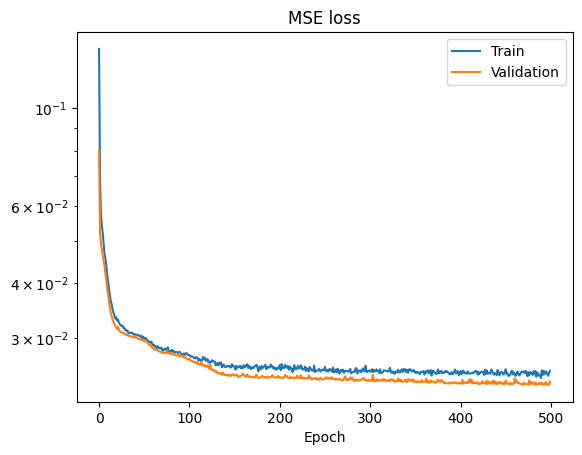

In [ ]:
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

# plt.ylim(0.001, 0.05)
plt.xlabel('Epoch')
plt.yscale('log')
plt.title('MSE loss')
plt.legend()
plt.show()

In [ ]:
np.min(val_losses)

0.023494498684174484

In [ ]:
class Autoencoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv1d(1, 10, kernel_size=7, stride=1, padding=3),
        nn.Conv1d(10, 20, kernel_size=7, stride=2, padding=3),
        nn.Conv1d(20, 10, kernel_size=7, stride=2, padding=3),
        nn.Conv1d(10, 1, kernel_size=7, stride=1, padding=3),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose1d(1, 1, kernel_size=7, stride=1, padding=3),
        # nn.ReLU(),
        nn.Dropout(0.2),
        nn.ConvTranspose1d(1, 10, kernel_size=7, stride=1, padding=3),
        # nn.ReLU(),
        nn.ConvTranspose1d(10, 20, kernel_size=7, stride=1, padding=3),
        # nn.ReLU(),
        nn.ConvTranspose1d(20, 10, kernel_size=7, stride=1, padding=3),
        # nn.ReLU(),
        nn.ConvTranspose1d(10, 1, kernel_size=7, stride=1, padding=3),
    )

  def forward(self, sample):
    latent = self.encoder(sample)
    reconstructed = self.decoder(latent)
    return reconstructed

  # class Autoencoder(torch.nn.Module):
  #   def __init__(self):
  #     super().__init__()
  #     self.encoder = nn.Sequential(
  #         nn.Conv1d(1, 10, kernel_size=7, stride=1),
  #         nn.ReLU(),
  #         nn.Conv1d(10, 20, kernel_size=7, stride=2),
  #         nn.ReLU(),
  #         nn.Conv1d(20, 10, kernel_size=7, stride=2),
  #         nn.ReLU(),
  #         nn.Conv1d(10, 1, kernel_size=7, stride=1),
  #         nn.ReLU(),
  #     )
  #     self.decoder = nn.Sequential(
  #         nn.ConvTranspose1d(1, 1, kernel_size=7, stride=1, padding=3),
  #         nn.ReLU(),
  #         nn.Dropout(0.2),
  #         nn.ConvTranspose1d(1, 10, kernel_size=7, stride=1, padding=3),
  #         nn.ReLU(),
  #         nn.ConvTranspose1d(10, 20, kernel_size=7, stride=1, padding=3),
  #         nn.ReLU(),
  #         nn.ConvTranspose1d(20, 10, kernel_size=7, stride=1, padding=3),
  #         nn.ReLU(),
  #         nn.ConvTranspose1d(10, 1, kernel_size=7, stride=1, padding=3),
  #     )


In [ ]:
big_data = torch.FloatTensor(big_data).
encoder = Autoencoder()
output = encoder(big_data[0])
print(output.shape)reshape(3000, 1, -1)

torch.Size([1, 100])


In [ ]:
x_train, x_val = train_test_split(big_data, test_size=0.75, shuffle=False)
train_loader = torch.utils.data.DataLoader(x_train, batch_size=10)
val_loader = torch.utils.data.DataLoader(x_val, batch_size=10)


n_epochs = 500
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        # print(X_batch)
        optimizer.zero_grad()
        reconstructed = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed = model(X_batch.to(device))
          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))




<ipython-input-47-f727808f6906>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/500 [00:00<?, ?it/s]

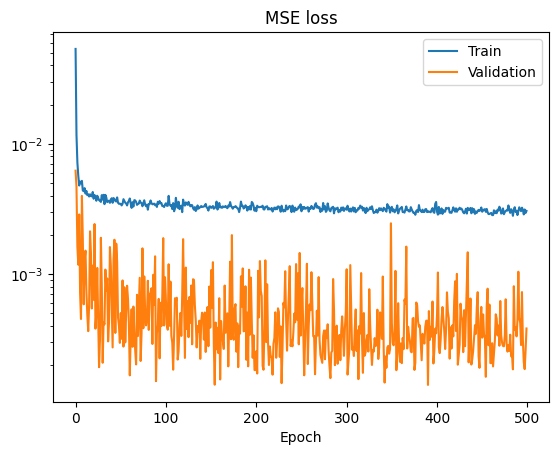

0.00014053525170311333

In [ ]:
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

# plt.ylim(0.00001, 0.001)
plt.xlabel('Epoch')
plt.yscale('log')
plt.title('MSE loss')
plt.legend()
plt.show()

np.min(val_losses)

In [ ]:
import keras

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 12.3 MB/s eta 0:00:00


In [ ]:
import visualkeras

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model

In [ ]:
 model = keras.Sequential(
    [
        keras.layers.Conv1D(50, 7, activation="relu", padding="same"),
        keras.layers.MaxPooling1D(1, padding="same"),
        keras.layers.Conv1D(25, 7, activation="relu", padding="same"),
        keras.layers.MaxPooling1D(2, padding="same"),
        keras.layers.Conv1D(13, 7, activation="relu", padding="same"),
        keras.layers.MaxPooling1D(2, padding="same"),
        keras.layers.Conv1D(7, 7, activation="relu", padding="same"),
        keras.layers.MaxPooling1D(2, padding="same"),

    ]
)

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show()

AttributeError: ignored

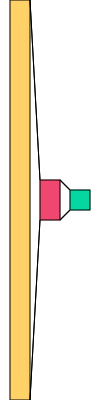

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import visualkeras


encoder_input = keras.Input(shape=(100,100, 1), name='img')
x = layers.Conv2D(filters = 100, kernel_size = 32, strides=(7, 7), activation='relu')(encoder_input)
# x = layers.Conv2D(filters = 100, kernel_size = 7, strides=(2, 2), activation='relu')(x)
# # x = layers.MaxPooling2D()(x)
# x = layers.Conv2D(filters = 100, kernel_size = 7, strides=(2, 2), activation='relu')(x)
# x = layers.Conv2D(filters = 100, kernel_size = 12, strides=(2, 2), activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')
# visualkeras.layered_view(encoder).show()
visualkeras.layered_view(encoder, legend=False, draw_volume=False)


# x = layers.Reshape((4, 4, 1))(encoder_output)
# x = layers.Conv2DTranspose(16, 7, activation='relu')(x)
# x = layers.Conv2DTranspose(32, 7, activation='relu')(x)
# x = layers.UpSampling2D(7)(x)
# x = layers.Conv2DTranspose(16, 7, activation='relu')(x)
# decoder_output = layers.Conv2DTranspose(1, 7, activation='relu')(x)
# autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=535909114817f12f5127e79da0de5d481e31c1fa0d334197de7d7f0f515df436
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


torch.Size([1, 100])
torch.Size([1, 10])


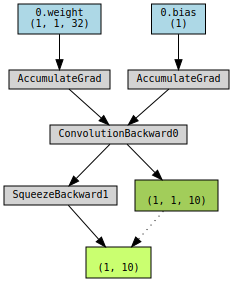

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchviz import make_dot

encoder = nn.Sequential(
      nn.Conv1d(1, 1, kernel_size=32, stride=7, padding=0),
      # nn.Conv1d(10, 20, kernel_size=7, stride=2, padding=3),
      # nn.Conv1d(20, 10, kernel_size=7, stride=2, padding=3),
      # nn.Conv1d(10, 1, kernel_size=12, stride=2, padding=3),
)

# big_data = torch.FloatTensor(big_data[0]).reshape(1, 1, -1)
# encoder = Autoencoder()
print(big_data[0].shape)
output = encoder(big_data[0])
print(output.shape)

make_dot(output, params=dict(encoder.named_parameters()))

# encoder_input = keras.Input(shape=(100, 1), name='img')
# x = layers.Linear(100, 50, monotonicities='increasing',normalization_order=1)(encoder_input)
# x = layers.Linear(50, 25, monotonicities='increasing',normalization_order=1)(x)
# # x = layers.MaxPooling2D()(x)
# x = layers.Linear(25, 13, monotonicities='increasing',normalization_order=1)(x)
# x = layers.Linear(13, 7, monotonicities='increasing',normalization_order=1)(x)
# # encoder_output = layers.GlobalMaxPooling2D()(x)
# encoder = keras.Model(encoder_input, encoder_output, name='encoder')
# visualkeras.layered_view(encoder).show()


# x = layers.Reshape((4, 4, 1))(encoder_output)
# x = layers.Conv2DTranspose(16, 7, activation='relu')(x)
# x = layers.Conv2DTranspose(32, 7, activation='relu')(x)
# x = layers.UpSampling2D(7)(x)
# x = layers.Conv2DTranspose(16, 7, activation='relu')(x)
# decoder_output = layers.Conv2DTranspose(1, 7, activation='relu')(x)
# autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.keras import layers
import visualkeras

model = Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(100,1)))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(13, activation='relu'))
model.add(layers.Dense(7, activation='relu'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

encoder_input = keras.Input(shape=(100, ), name='img')
# print(model(encoder_input))

visualkeras.layered_view(model, legend=False, draw_volume=False)

encoder_input = keras.Input(shape=(100, 1), name='img')
x = layers.Dense(50, activation='relu')(encoder_input)
x = layers.Dense(25, activation='relu')(x)
# x = layers.MaxPooling2D()(x)
x = layers.Dense(13, activation='relu')(x)
x = layers.Dense(7, activation='sigmoid')(x)
encoder_output = x
encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#visualkeras.layered_view(encoder, legend=False, draw_volume=False)

AttributeError: ignored